In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import sys

from scipy.stats import gamma, beta
import talib
from tqdm.notebook import tqdm
from functools import partial
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

c:\Users\Lukas.Schumacher\miniconda3\envs\cogModeling\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [28]:
sys.path.append("../src")
from networks_10092022 import DynamicGaussianNetworkFactorized
from priors import diffusion_prior, random_walk_prior
from micro_models import dynamic_batch_diffusion, diffusion_trial, fast_dm_simulate
from macro_models import random_walk_shared_var, random_walk
from context import generate_design_matrix
from transformations import scale_z, unscale_z

In [3]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [33]:
N_OBS      = 3200
BATCH_SIZE = 8
N_SAMPLES  = 50
N_PARAMS   = 6
N_SIM      = 25

PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [5]:
MACRO_MEAN  = beta(a=1, b=25).mean()
MACRO_STD   = beta(a=1, b=25).std()
MICRO_MEANS = [1.75, 1.75, 1.75, 1.75, 1.7, 1] # calculated based on 10000 simulated theta_1:3200
MICRO_STDS   = [1.5, 1.5, 1.5, 1.5, 1.25, 1] # calculated based on 10000 simulated theta_1:3200

In [6]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [7]:
def generator_fun(batch_size, T):
    theta = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
    eta = random_walk_prior(batch_size, N_PARAMS)
    theta_t = random_walk(theta, eta, T)
    context = generate_design_matrix(batch_size, T)
    rt = dynamic_batch_diffusion(theta_t, context).astype(np.float32)
    x = tf.concat((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    
    theta_t_z = theta_t.copy()
    for i in range(theta_t.shape[0]):
        theta_t_z[i] =  scale_z(theta_t[i], MICRO_MEANS,  MICRO_STDS)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x

In [8]:
%%time
eta_z, theta_t_z, rt = generator_fun(BATCH_SIZE, N_OBS)
theta_t_z.shape

Wall time: 2.15 s


(8, 3200, 6)

In [9]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            macro_params, micro_params, data = generator() 

            # Forward pass
            macro_params_hat, micro_params_hat = network(data, micro_params)

            # loss computation
            loss_macro = nll(macro_params, macro_params_hat)
            loss_micro = nll(micro_params, micro_params_hat)
            total_loss = loss_macro + loss_micro
        
        # One step backprop
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss.Macro: {:.3f},Loss.Micro: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss_macro.numpy(), loss_micro.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [10]:
simulator = partial(generator_fun, T=N_OBS, batch_size=BATCH_SIZE)
epochs = 50
steps_per_epoch = 1000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=5000,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [11]:
network_settings = {
    'embedding_gru_units': 256, 
    'embedding_lstm_units' : 256,
    'dense_pre_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'dense_micro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'dense_macro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'macro_lstm_units': 128,
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetworkFactorized(network_settings)

In [ ]:
# losses = []
# for ep in range(1, epochs+1):
#     with tqdm(total=steps_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses_ep = epoch_trainer(simulator, network, optimizer, steps_per_epoch, p_bar)
#         losses.append(losses_ep)

In [ ]:
# network.save_weights('../trained_networks/full_dynamic_dm_3200_factorized_20_Sept')

## Evaluation

In [12]:
network.load_weights('../trained_networks/full_dynamic_dm_3200_factorized_20_Sept')

In [13]:
data = pd.read_csv('../data/data_lexical_decision.csv', sep=',', header=0)

In [14]:
# read data
data = pd.read_csv('../data/data_lexical_decision.csv', sep=',', header=0)

# prepare data for fitting
ids = np.unique(data.id)
N_SUBS = len(ids)

# negative rts for error responses
data.rt.loc[data.acc == 0] = -data.rt.loc[data.acc == 0]

# iterate over subjects
x_nn = np.zeros((len(ids), N_OBS, 5))

for id in ids:
    person_data = data[data.id == id]
    rt = np.array([person_data.rt])[:, :, np.newaxis]
    stim_type = np.array([person_data.stim_type])[:, :, np.newaxis] - 1 
    context = to_categorical(stim_type)
    x_nn[id-1] = tf.concat((rt, context), axis=-1)

x_nn.shape

c:\Users\Lukas.Schumacher\miniconda3\envs\cogModeling\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(11, 3200, 5)

In [15]:
# # amortized inference
# post_eta = np.zeros((N_SAMPLES, N_SUBS, N_PARAMS))
# post_theta_t = np.zeros((N_SAMPLES, N_SUBS, N_OBS, N_PARAMS))
# for i in range(len(ids)):
#     post_eta[:, i:i+1, :], post_theta_t[:, i:i+1, :, :] = network.sample_n(x_nn[i:i+1], N_SAMPLES)
#     print("Sub nr. {} is fitted".format(i+1))

Sub nr. 1 is fitted
Sub nr. 2 is fitted
Sub nr. 3 is fitted
Sub nr. 4 is fitted
Sub nr. 5 is fitted
Sub nr. 6 is fitted
Sub nr. 7 is fitted
Sub nr. 8 is fitted
Sub nr. 9 is fitted
Sub nr. 10 is fitted
Sub nr. 11 is fitted


In [16]:
# post_eta = unscale_z(post_eta, MACRO_MEAN, MACRO_STD)
# post_theta_t = unscale_z(post_theta_t, MICRO_MEANS, MICRO_STDS)

In [17]:
# np.save("post_eta_all_sub_factorized_20Sept", post_eta)
# np.save("post_theta_ta_all_sub_factorized_20Stept", post_theta_t)

In [ ]:
post_eta = np.load("post_eta_all_sub_factorized_20Sept.npy")
post_theta_t = np.load("post_theta_ta_all_sub_factorized_20Stept.npy")

In [20]:
# read fast-dm parameter estimates
fast_dm_params = pd.read_csv('../data/parameters_full_ddm_error_coding_cs.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)
fast_dm_params = fast_dm_params.to_numpy()[:, 1:]
fast_dm_params.shape

(11, 8)

In [23]:
# predict data with fast_dm for all subjects
pred_rt_fast_dm = np.zeros((N_SUBS, N_OBS))
for i in range(N_SUBS):
    context = data.stim_type.loc[data.id == i+1].to_numpy() - 1
    pred_rt_fast_dm[i] = fast_dm_simulate(fast_dm_params[i], context)
    
pred_rt_fast_dm.shape

(11, 3200)

## Evaluation: RT over time

In [29]:
def pr_check(emp_data, post_theta_t, n_sim, sma_period=5):
    # get experimental context
    context = emp_data.stim_type.values - 1
    # get empirical response times
    emp_rt = np.abs(emp_data.rt.values)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    
    # sample from posterior
    idx = np.arange(0, N_SAMPLES-1, N_SAMPLES/n_sim, dtype=np.int32)
    theta = post_theta_t[idx]

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(theta[sim, t, context[t]], theta[sim, t, 4], theta[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt, emp_rt, sma_emp_rt

In [34]:
# # predict data with neural for all subjects
# pred_rt_neural = np.zeros((N_SUBS, N_SIM, N_OBS))
# sma_pred_rt_neural = np.zeros((N_SUBS, N_SIM, N_OBS))

# pred_rt_quantiles = np.zeros((N_SUBS, 2, N_OBS))
# pred_rt_medians = np.zeros((N_SUBS, N_OBS))

# emp_rt =  np.zeros((N_SUBS, N_OBS))
# sma_emp_rt =  np.zeros((N_SUBS, N_OBS))

# for sub in range(N_SUBS):
#     # predict RTs
#     person_data = data[data.id == sub+1]
#     pred_rt_neural[sub], sma_pred_rt_neural[sub], emp_rt[sub], sma_emp_rt[sub] = pr_check(person_data, post_theta_t[:, sub, :, :], N_SIM)
#     # compute RT quantiles
#     pred_rt_quantiles[sub] = np.quantile(sma_pred_rt_neural[sub], [0.05, 0.95], axis=0)
#     pred_rt_medians[sub] = np.median(sma_pred_rt_neural[sub], axis=0)
#     print("Sub nr. {} is fitted".format(sub+1))

Sub nr. 1 is fitted
Sub nr. 2 is fitted
Sub nr. 3 is fitted
Sub nr. 4 is fitted
Sub nr. 5 is fitted
Sub nr. 6 is fitted
Sub nr. 7 is fitted
Sub nr. 8 is fitted
Sub nr. 9 is fitted
Sub nr. 10 is fitted
Sub nr. 11 is fitted


In [36]:
# np.save("pred_rt_neural_factorized", pred_rt_neural)
# np.save("sma_pred_rt_neural_factorized", sma_pred_rt_neural)
# np.save("pred_rt_quantiles_factorized", pred_rt_quantiles)
# np.save("pred_rt_medians_factorized", pred_rt_medians)
# np.save("emp_rt_factorized", emp_rt)
# np.save("sma_emp_rt_factorized", sma_emp_rt)

In [ ]:
pred_rt_neural = np.load("pred_rt_neural_factorized.npy")
sma_pred_rt_neural = np.load("sma_pred_rt_neural_factorized.npy")
pred_rt_quantiles = np.load("pred_rt_quantiles_factorized.npy")
pred_rt_medians = np.load("pred_rt_medians_factorized.npy")
emp_rt = np.load("emp_rt_factorized.npy")
sma_emp_rt = np.load("sma_emp_rt_factorized.npy")

In [40]:
horizon=800
emp_data_horizon = x_nn[:, :N_OBS-horizon, :]

# inference on restircted data
post_eta_z_horizon = np.zeros((N_SAMPLES, N_SUBS, N_PARAMS))
post_theta_t_z_horizon = np.zeros((N_SAMPLES, N_SUBS, N_OBS-horizon, N_PARAMS))
for i in range(len(ids)):
    post_eta_z_horizon[:, i:i+1, :], post_theta_t_z_horizon[:, i:i+1, :, :] = network.sample_n(emp_data_horizon[i:i+1], N_SAMPLES)
    print("Sub nr. {} is fitted".format(i+1))

Sub nr. 1 is fitted
Sub nr. 2 is fitted
Sub nr. 3 is fitted
Sub nr. 4 is fitted
Sub nr. 5 is fitted
Sub nr. 6 is fitted
Sub nr. 7 is fitted
Sub nr. 8 is fitted
Sub nr. 9 is fitted
Sub nr. 10 is fitted
Sub nr. 11 is fitted


In [43]:
post_eta_last = unscale_z(post_eta_z_horizon, MACRO_MEAN, MACRO_STD)
post_theta_last = unscale_z(post_theta_t_z_horizon[:, :, -1, :], MICRO_MEANS,  MICRO_STDS)

In [44]:
# calcualte mean posteriors
post_eta_last_means = post_eta_last.mean(axis=0)
post_theta_last_means = post_theta_last.mean(axis=0)

In [46]:
# generate dynamic parameters and simulate RTs
pred_rt_horizon = np.zeros((N_SIM, N_SUBS, horizon, 1))
sma_pred_rt_horizon = np.zeros((N_SIM, N_SUBS, horizon, 1))

context = x_nn[:, :, 1:].argmax(axis=2)[:, N_OBS-horizon:]

for sub in range(N_SUBS):
    for i in range(N_SIM):
        pred_theta_t = random_walk(post_theta_last_means[sub:sub+1], post_eta_last_means[sub:sub+1], horizon)
        pred_rt_horizon[i, sub:sub+1] = np.abs(dynamic_batch_diffusion(pred_theta_t, context[sub:sub+1]).astype(np.float32))
        sma_pred_rt_horizon[i, sub, :, 0] = talib.SMA(pred_rt_horizon[i, sub, :, 0], timeperiod=5)

    print("Sub nr. {} is predicted".format(sub+1))

Sub nr. 1 is predicted
Sub nr. 2 is predicted
Sub nr. 3 is predicted
Sub nr. 4 is predicted
Sub nr. 5 is predicted
Sub nr. 6 is predicted
Sub nr. 7 is predicted
Sub nr. 8 is predicted
Sub nr. 9 is predicted
Sub nr. 10 is predicted
Sub nr. 11 is predicted


In [47]:
pred_rt_horizon_medians = np.median(sma_pred_rt_horizon, axis=0)
pred_rt_horizon_quantiles = np.quantile(sma_pred_rt_horizon, [0.05, 0.95], axis=0)

In [48]:
def reorderLegend2(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,
              fontsize=16, loc='upper right')
    return(handles, labels)

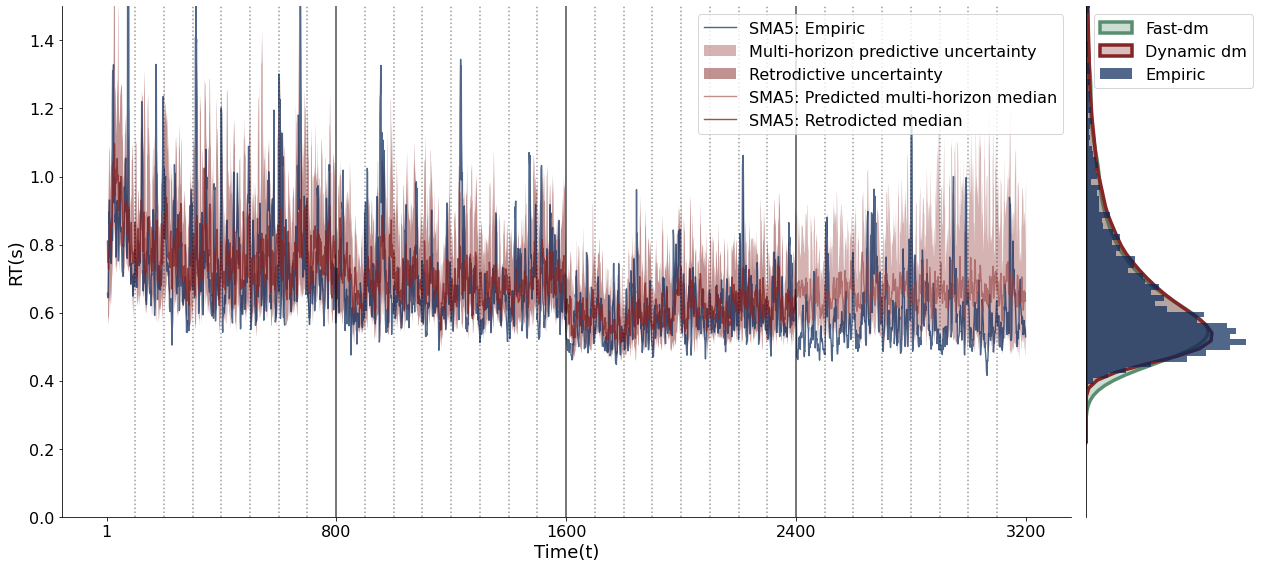

In [49]:
# initialize figure
f, ax = plt.subplots(1, 2, figsize=(18, 8),
                     gridspec_kw={'width_ratios': [6, 1]})
axrr = ax.flat
# plot empiric and predicted response times series
time = np.arange(N_OBS) 

"#e65a09"

axrr[0].plot(time, sma_emp_rt[0], color="#062759", lw=1.4, alpha=0.7, label='SMA5: Empiric')
axrr[0].plot(time[:N_OBS-horizon], pred_rt_medians[0, :N_OBS-horizon], color='#852626', lw=1.4, label='SMA5: Retrodicted median', alpha=0.8)
axrr[0].plot(time[N_OBS-horizon:], pred_rt_horizon_medians[0], color="#964242", lw=1.4, label='SMA5: Predicted multi-horizon median', alpha=0.6)
axrr[0].fill_between(time[N_OBS-horizon:], pred_rt_horizon_quantiles[0, 0, :, 0], pred_rt_horizon_quantiles[1, 0, :, 0], color="#964242", linewidth=0, alpha=0.4, label='Multi-horizon predictive uncertainty')
axrr[0].fill_between(time[:N_OBS-horizon], pred_rt_quantiles[0, 0, :N_OBS-horizon], pred_rt_quantiles[0, 1, :N_OBS-horizon], color='#852626', linewidth=0, alpha=0.5, label='Retrodictive uncertainty')
for idx in np.argwhere(person_data.session.diff().values == 1):
    if idx == 800:
        axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
    else:
        axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
for idx in np.argwhere(person_data.block.diff().values == 1):
    if idx == 100:
        axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
    else:
        axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
sns.despine(ax=axrr[0])
axrr[0].grid(alpha=0.3)
axrr[0].set_ylabel('RT(s)', fontsize=18)
axrr[0].set_xlabel('Time(t)', fontsize=18)
axrr[0].tick_params(axis='both', which='major', labelsize=16)
reorderLegend2(axrr[0],['SMA5: Empiric', 'SMA5: Predicted median', 'Predictive uncertainty'])
axrr[0].grid(b=None)
axrr[0].set_xticks([1, 800, 1600, 2400, 3200])

# plot empiric and predicted response time dist
plt.setp(ax, ylim=(0, 1.5))
sns.histplot(y=np.abs(emp_rt[0]), fill="#062759", color="#062759", alpha=0.7, label="Empiric", ax=axrr[1], stat="density", bins=250, linewidth=0)
sns.kdeplot(y=np.abs(pred_rt_fast_dm[0]), fill= "#598f70", color="#598f70", alpha=0.3, label="Fast-dm", ax=axrr[1], linewidth=3.5)
sns.kdeplot(y=pred_rt_neural[0].flatten(), fill="#852626", color="#852626", alpha=0.3, label="Dynamic dm", ax=axrr[1], linewidth=3.5)

axrr[1].legend(fontsize=16)
axrr[1].set_xlabel('', fontsize=18)
axrr[1].tick_params(axis='both', which='major', labelsize=16)
axrr[1].set_yticklabels('')
axrr[1].set_xticklabels('')
axrr[1].xaxis.set_ticks([])
axrr[1].yaxis.set_ticks([])
axrr[1].get_xaxis().set_visible(False)
for line in axrr[1].get_lines():
    line.set_alpha(1)
sns.despine(ax=axrr[1], bottom=True)
plt.subplots_adjust(wspace = 0.05)
f.tight_layout()
# f.savefig("plots/rt_time_series.png", dpi=300)

## Evaluation: Parameter Dynamics

In [26]:
def plot_dynamic_posteriors(dynamic_posterior, fast_dm_params, par_labels, par_names, 
                            ground_truths=None, color_pred='#852626'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
        
    means = dynamic_posterior.mean(axis=0)
    std = dynamic_posterior.std(axis=0)
    
    post_max = np.array(means).max(axis=0).max()
    upper_y_ax = post_max + 1

    sigma_factors = [1]
    alphas = [0.6]
    serif_font = "Computer Modern Roman"
    serif_font = "Palatino"

    time = np.arange(x_nn.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    counter = 0
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, label='Posterior mean')
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Posterior sd')
        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)', fontsize=18)
        ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=18)
        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks([1, 800, 1600, 2400, 3200])
        ax.tick_params(axis='both', which='major', labelsize=16)
        if i < 4:
            ax.set_ylim(0, upper_y_ax)
        else:
            ax.set_ylim(0)
        ax.grid(False)

        # vertical bars
        for idx in np.arange(799, 2400, 800):
            if idx == 799:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
            else:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        for idx in np.arange(99, 3100, 100):
            if idx == 99:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
            else:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)


        # horizontal fast-dm params
        if i <= 3:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[6], fast_dm_params[i] + fast_dm_params[6], color='#598f70', alpha=0.3, linewidth=0, label='Fast-dm variability')
        elif i == 4:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
        else:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[7]/2, fast_dm_params[i] + fast_dm_params[7]/2, color='#598f70', alpha=0.3, linewidth=0, label='Fast-dm variability')


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)

    f.tight_layout()
    f.savefig("../plots/param_dynamic_sub_{}_factorized.png".format(sub), dpi=300, bbox_inches="tight")

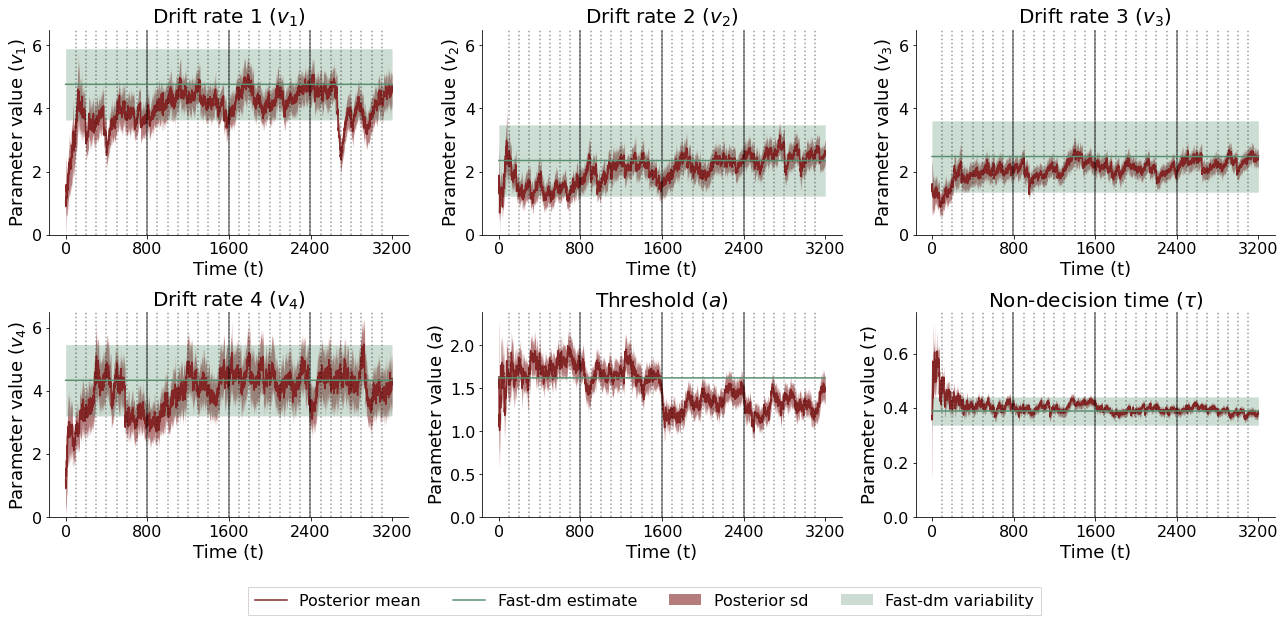

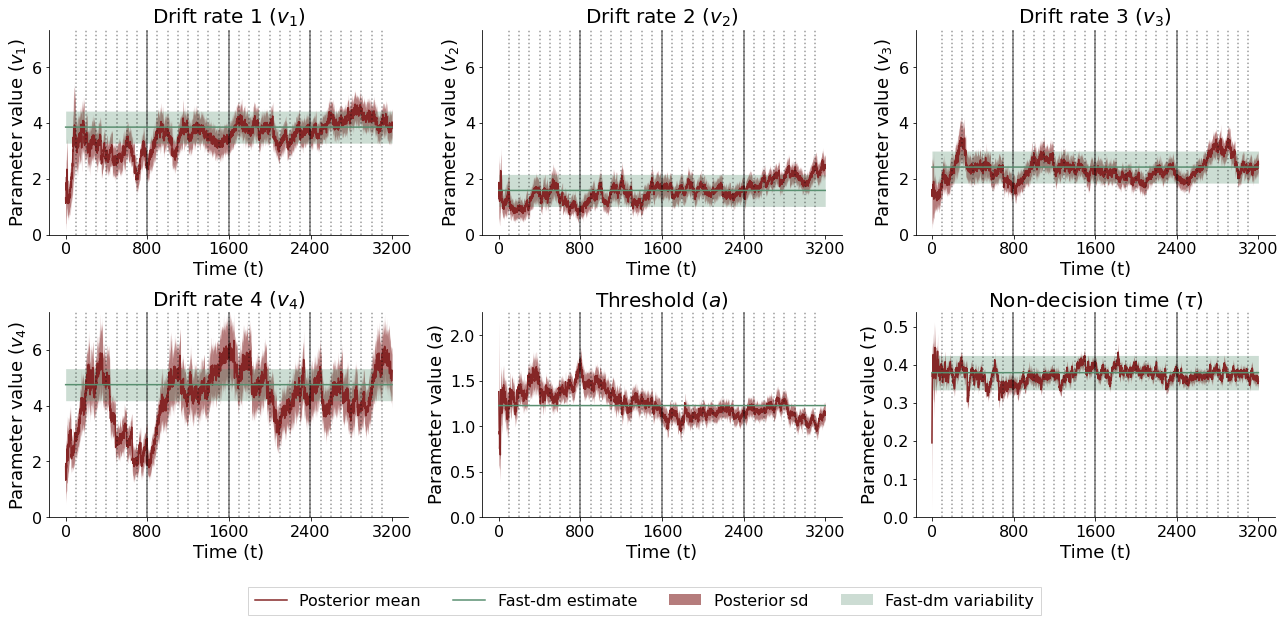

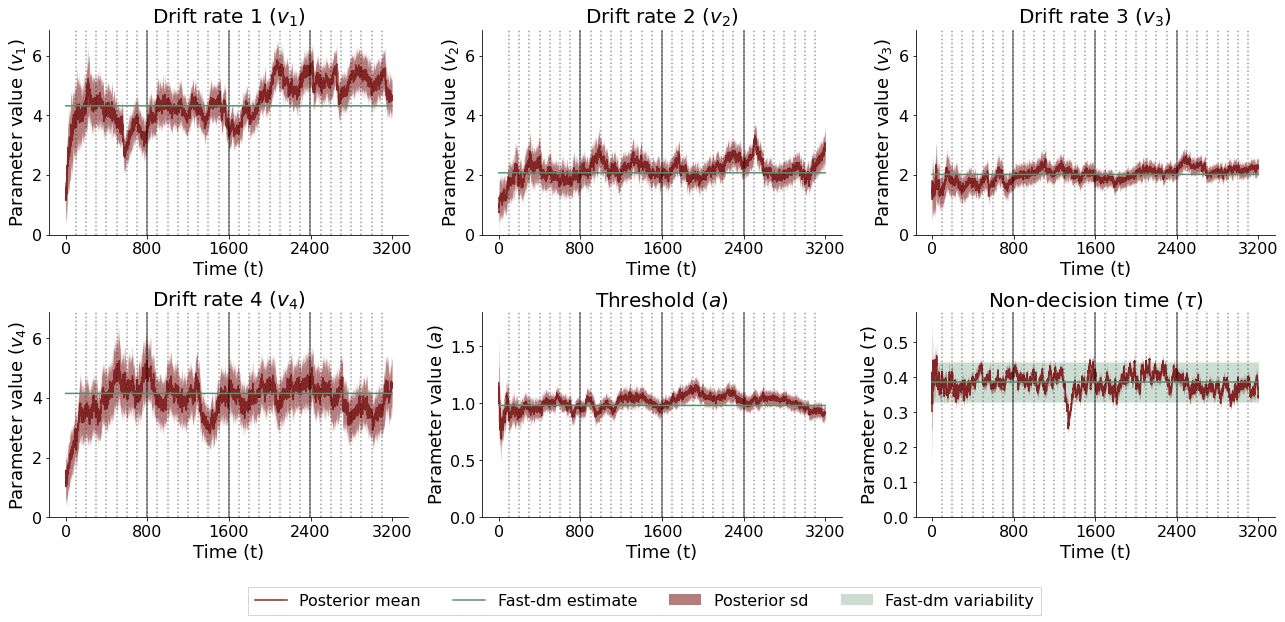

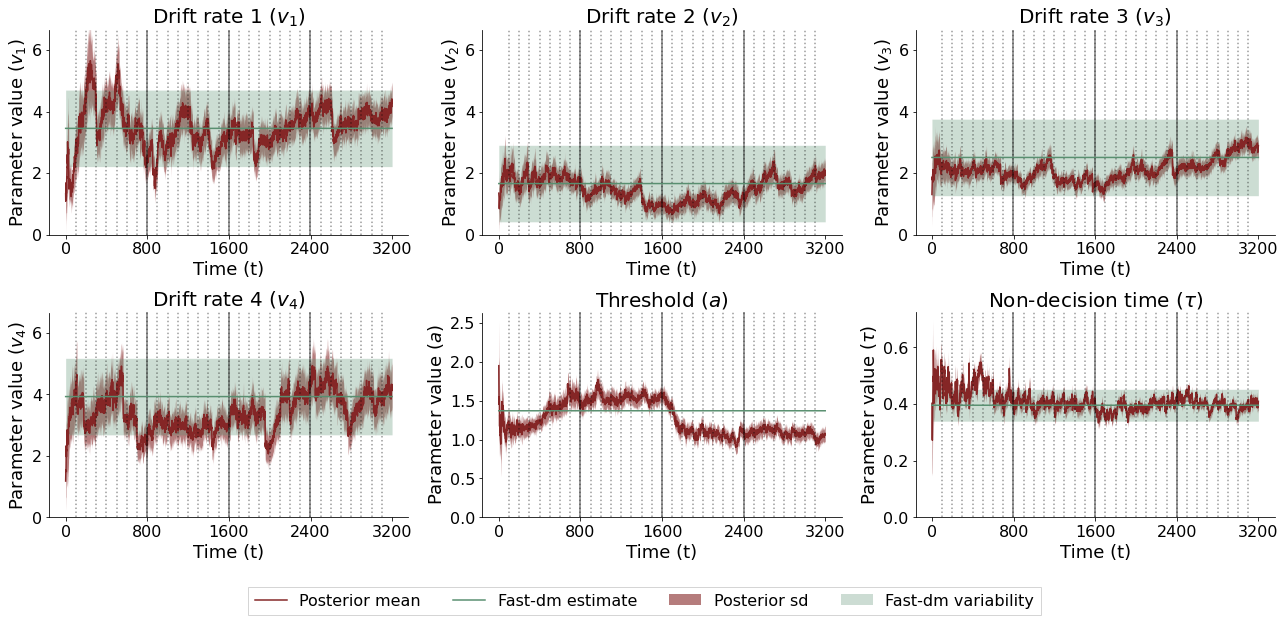

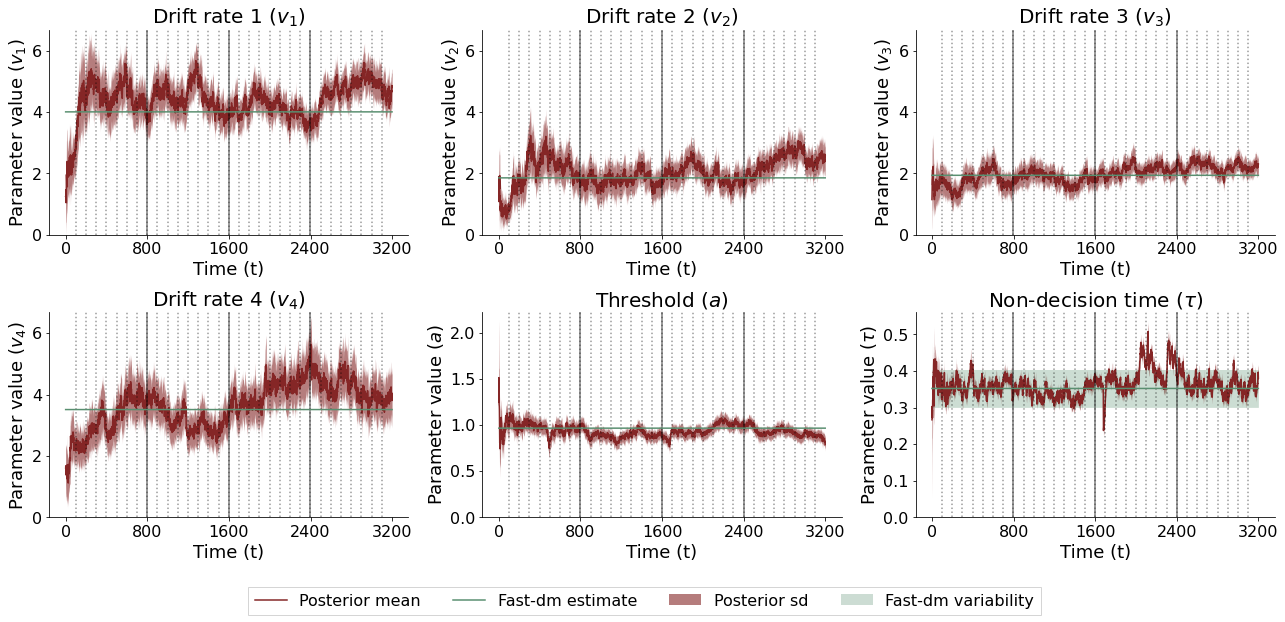

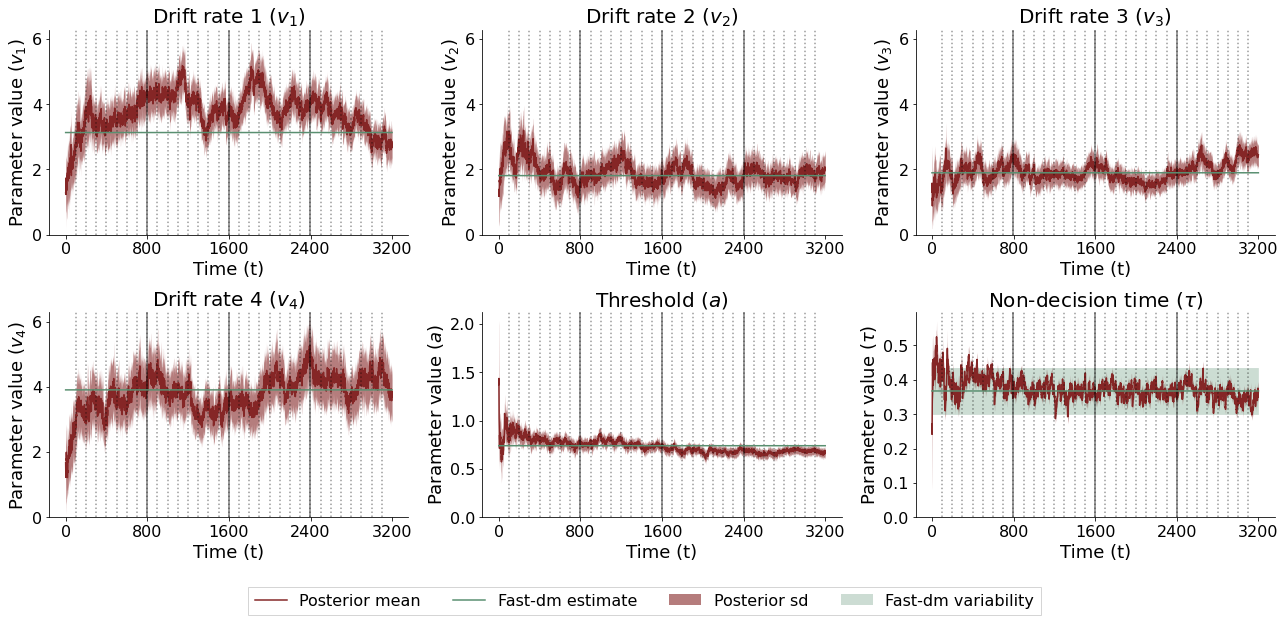

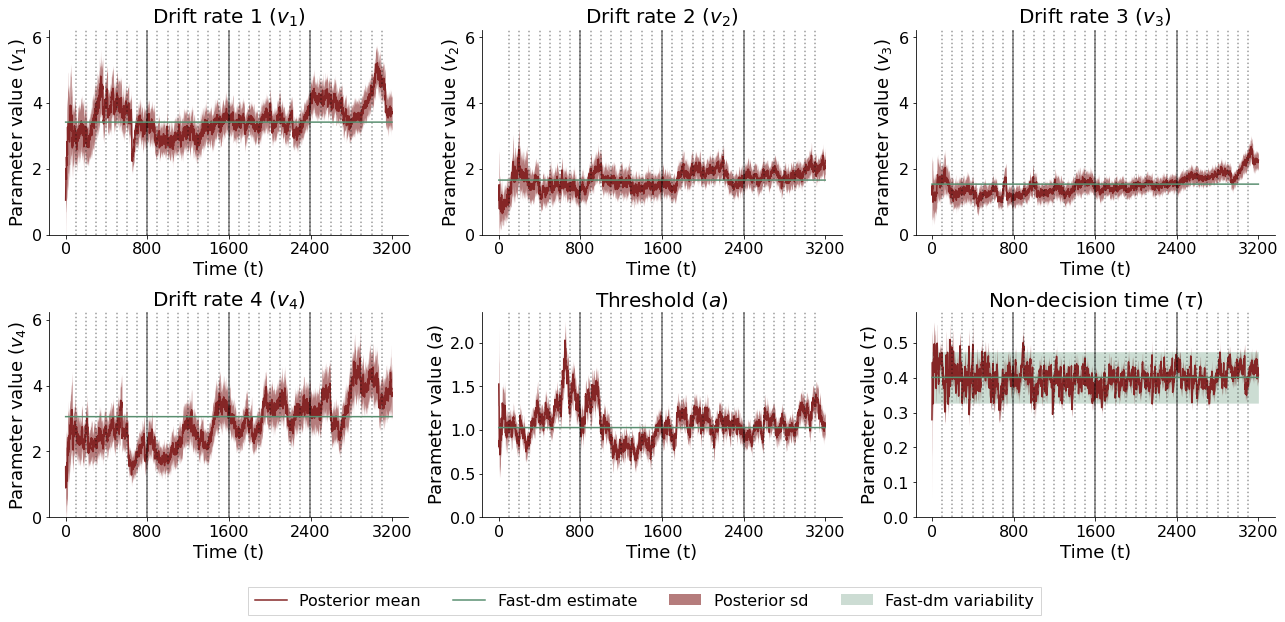

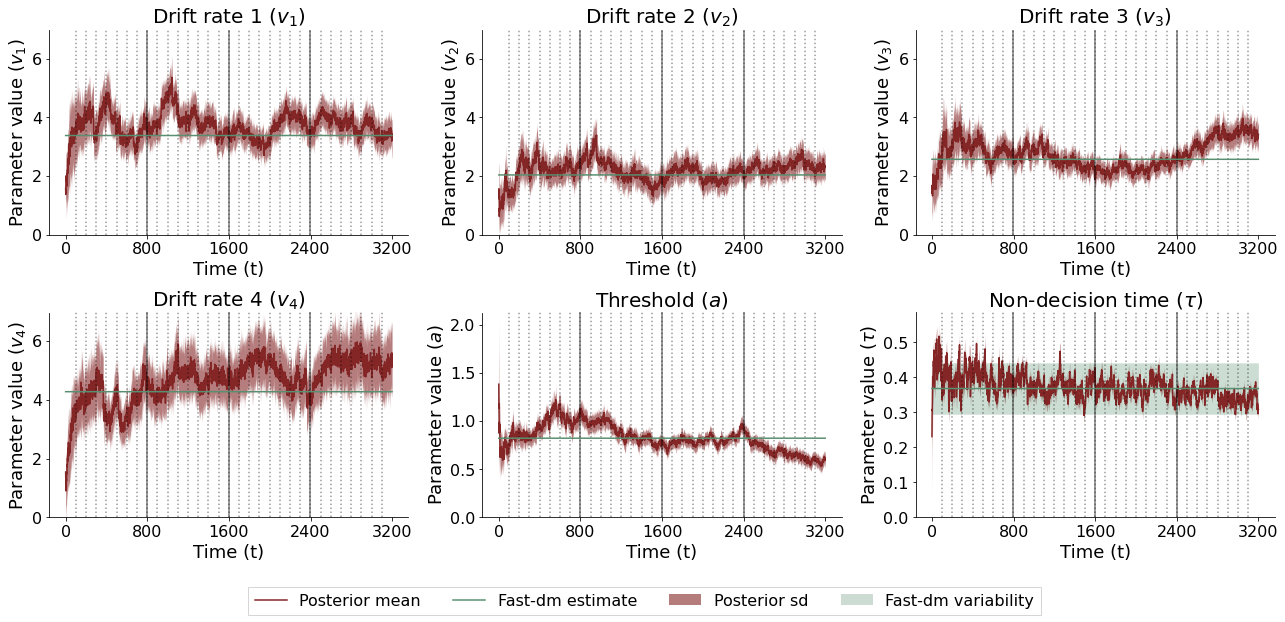

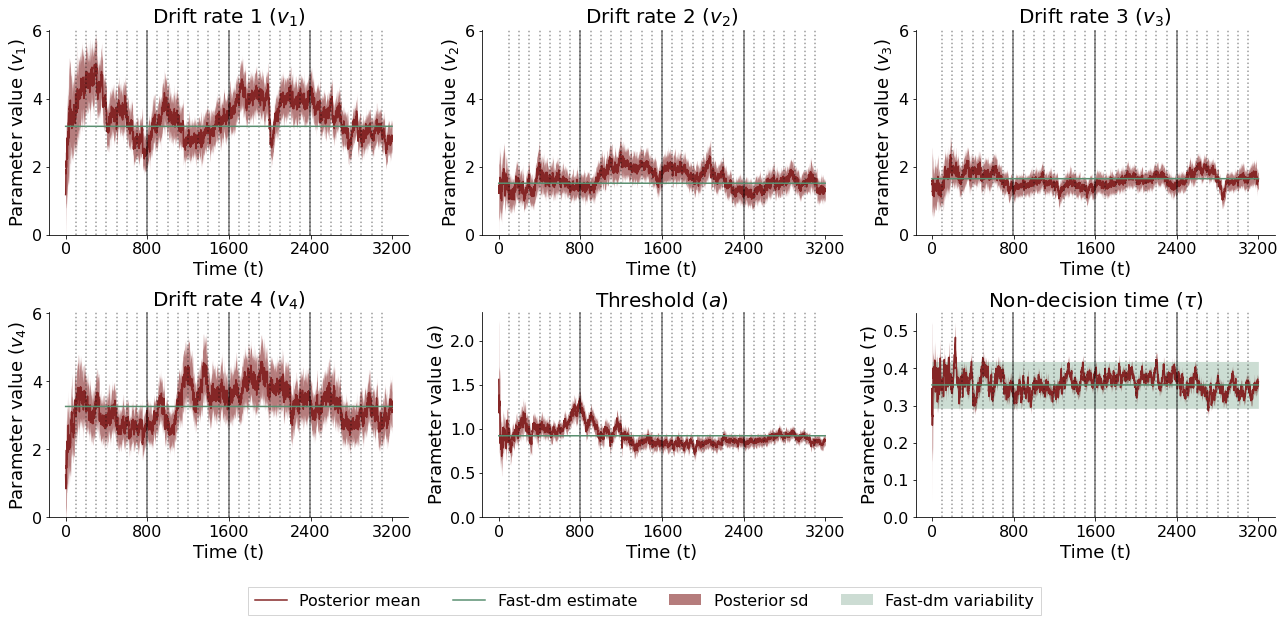

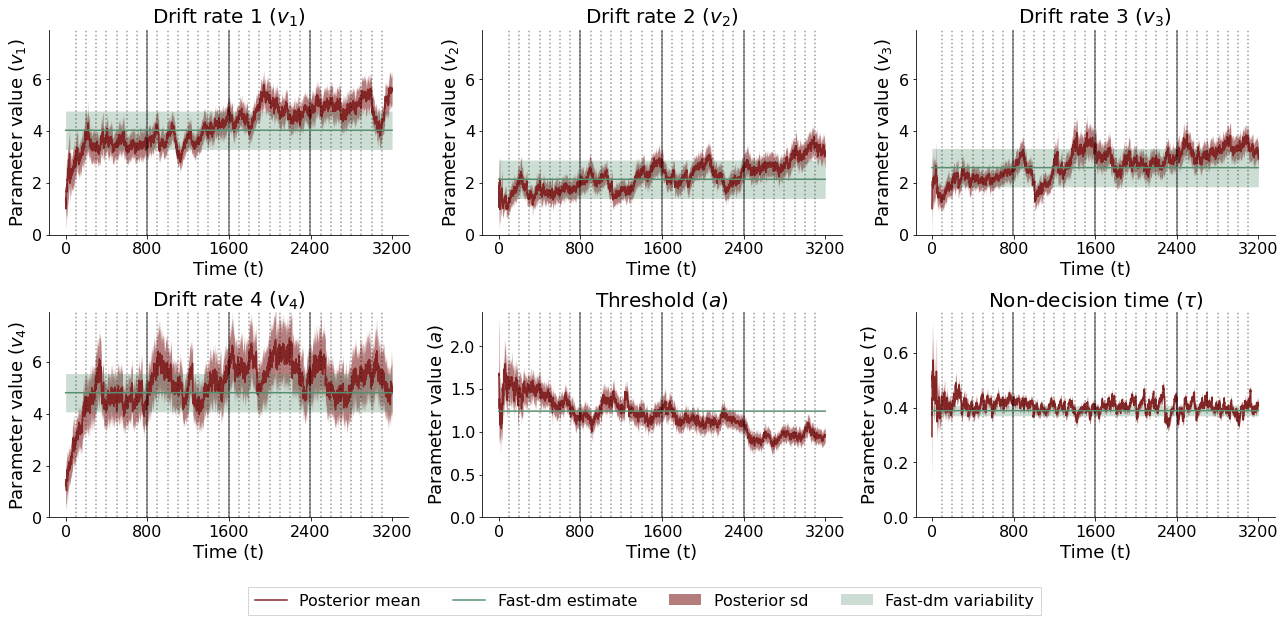

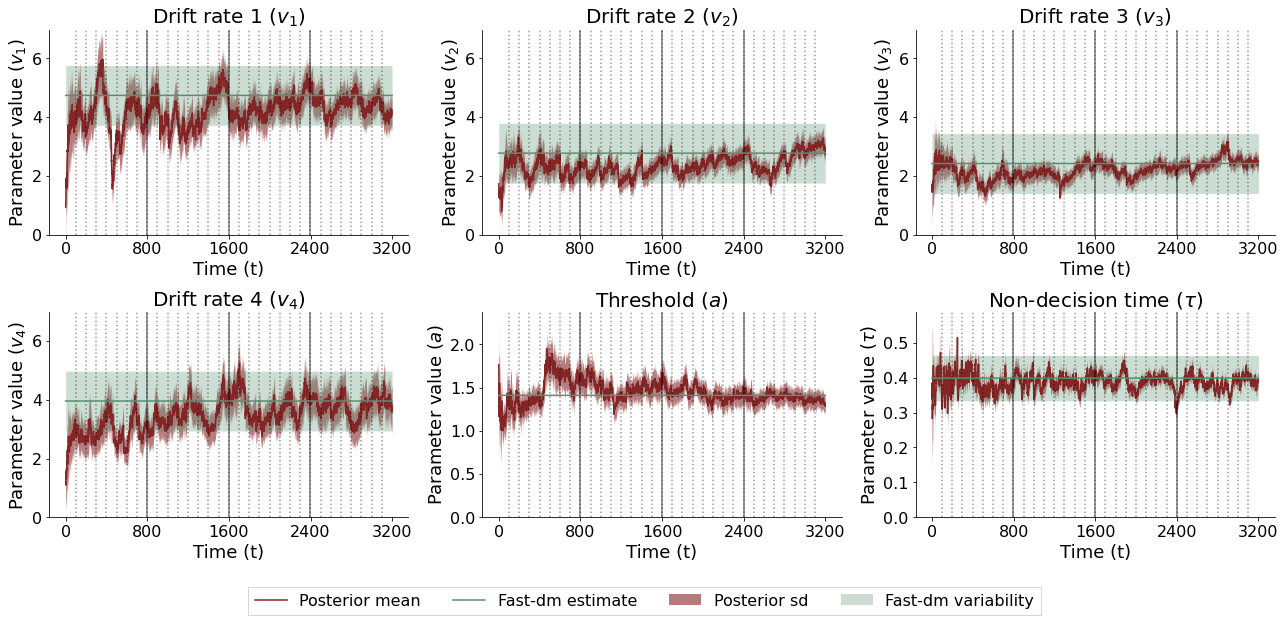

In [27]:
for sub in range(N_SUBS):
    plot_dynamic_posteriors(post_theta_t[:, sub, :, :], fast_dm_params[sub], PARAM_LABELS, PARAM_NAMES)

## Evaluation: Average Parameter Dynamic

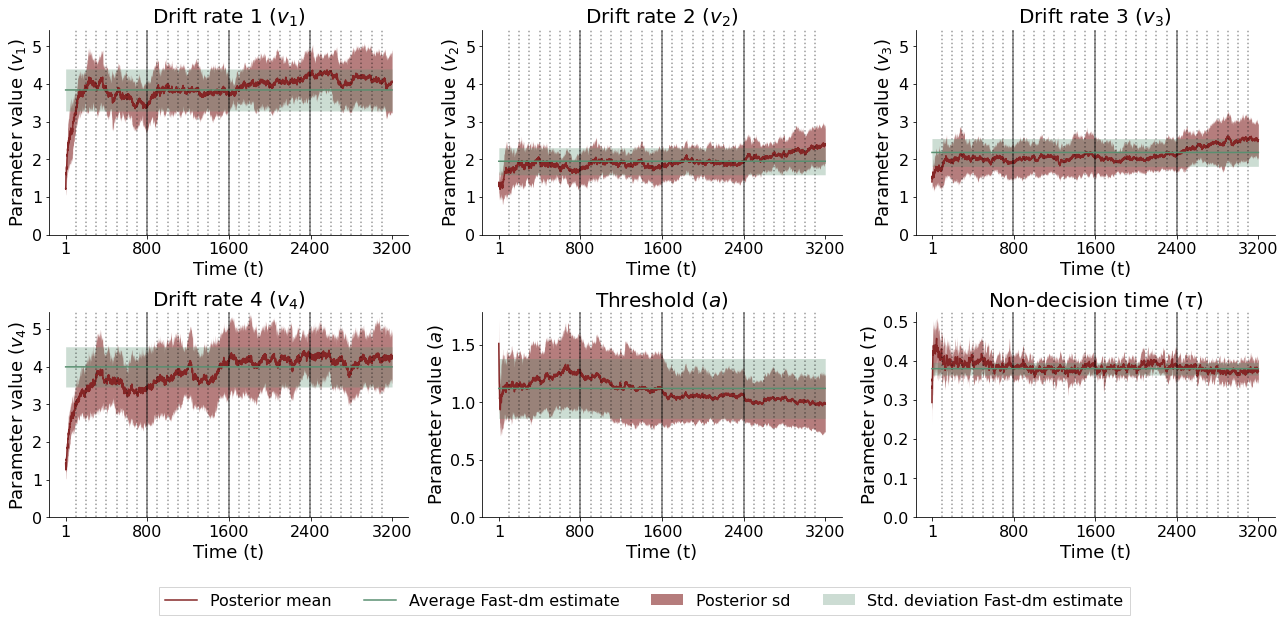

In [52]:
# Plot average parameter dynamc
color_pred='#852626'

# compute means and stds for neural and fast-dm parameters
neural_means = post_theta_t.mean(axis=0).mean(axis=0)
neural_stds = post_theta_t.mean(axis=0).std(axis=0)

fast_dm_means = fast_dm_params.mean(axis=0)
fast_dm_sd = fast_dm_params.std(axis=0)

post_max = np.array(neural_means).max(axis=0).max()
upper_y_ax = post_max + 1

sigma_factors = [1]
alphas = [0.6]

time = np.arange(N_OBS)
f, axarr = plt.subplots(2, 3, figsize=(18, 8))
for i, ax in enumerate(axarr.flat):
    ax.plot(time, neural_means[:, i], color=color_pred, label='Posterior mean')
    for sigma_factor, alpha in zip(sigma_factors, alphas):
        ci_upper = neural_means[:, i] + sigma_factor * neural_stds[:, i]
        ci_lower = neural_means[:, i] - sigma_factor * neural_stds[:, i]
        ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Posterior sd')
    sns.despine(ax=ax)
    ax.set_xlabel('Time (t)', fontsize=18)
    ax.set_ylabel('Parameter value ({})'.format(PARAM_NAMES[i]), fontsize=18)
    ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
    ax.set_xticks([1, 800, 1600, 2400, 3200])
    ax.tick_params(axis='both', which='major', labelsize=16)
    if i < 4:
        ax.set_ylim(0, upper_y_ax)
    else:
        ax.set_ylim(0)
    ax.grid(False)

    # vertical bars
    for idx in np.arange(799, 2400, 800):
        if idx == 799:
            ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        else:
            ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
    for idx in np.arange(99, 3100, 100):
        if idx == 99:
            ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
        else:
            ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)

    # horizontal fast-dm params
    ax.plot(time, np.repeat(fast_dm_means[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Average Fast-dm estimate')
    ax.fill_between(time, fast_dm_means[i] - fast_dm_sd[i], fast_dm_means[i] + fast_dm_sd[i], color='#598f70', alpha=0.3, linewidth=0, label='Std. deviation Fast-dm estimate')

    f.subplots_adjust(hspace=0.5)
    if i == 0:
        f.legend(fontsize=16, loc='center', 
                    bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)

f.tight_layout()
# f.savefig("plots/param_dynamic_sub_{}.png".format(sub), dpi=300, bbox_inches="tight")